In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch, torch.nn as nn
import Loader_forPPMI as Loader
import Judge
import time
from Models.Net import Model as MLP

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

 OP0, NG0

In [2]:
LR = 0.005
EPOCH = 300
n_fold = 20
TURN = 1
if_PRINT = True
if_valiSet = False

acc_list_total = []
best_roc_list, best_sen_list, best_spe_list = [], [], []
acc_TURN = []

in epoch 299, test acc = 0.82 / 0.85(epoch:298) time: 15.4813s


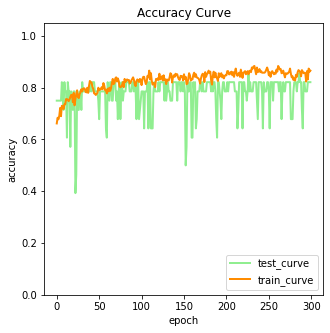

in epoch 299, test acc = 0.57 / 0.64(epoch:71) time: 11.7077s


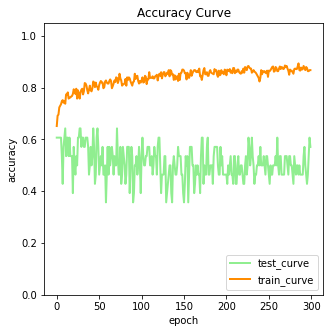

in epoch 299, test acc = 0.54 / 0.75(epoch:171) time: 11.5688s


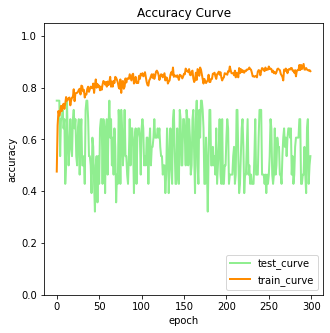

in epoch 299, test acc = 0.74 / 0.83(epoch:63) time: 11.5857s


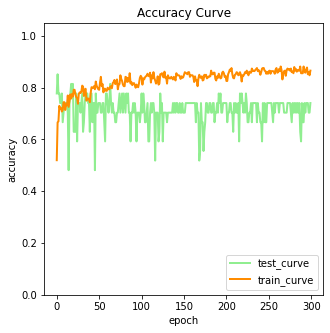

in epoch 299, test acc = 0.56 / 0.68(epoch:290) time: 12.1067s


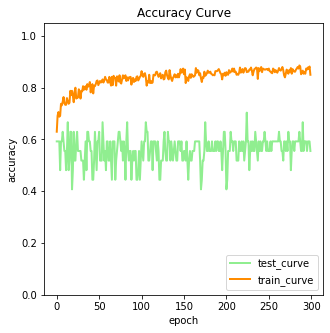

in epoch 299, test acc = 0.7 / 0.81(epoch:38) time: 12.5124s


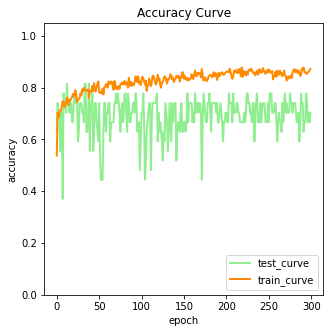

in epoch 299, test acc = 0.7 / 0.74(epoch:296) time: 12.4186s


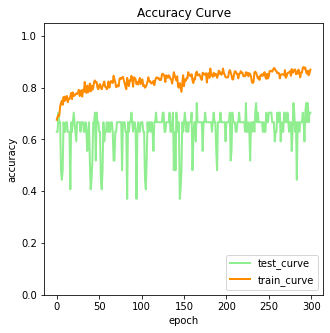

in epoch 299, test acc = 0.7 / 0.77(epoch:298) time: 12.4054s


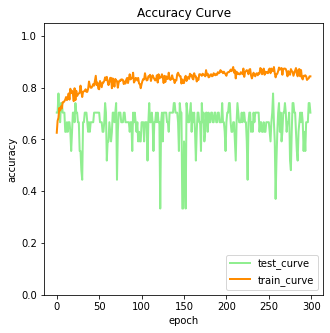

in epoch 299, test acc = 0.7 / 0.78(epoch:298) time: 12.3807s


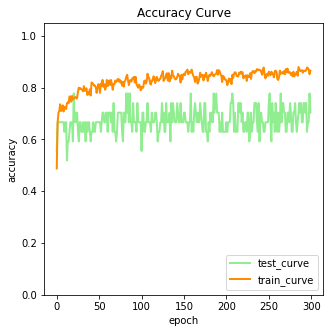

in epoch 299, test acc = 0.59 / 0.68(epoch:297) time: 12.3965s


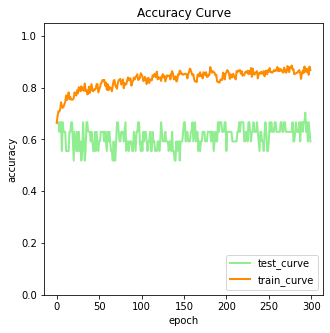

in epoch 299, test acc = 0.56 / 0.67(epoch:285) time: 12.4104s


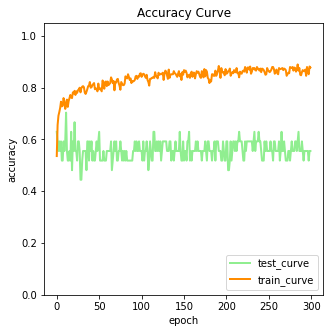

in epoch 299, test acc = 0.63 / 0.73(epoch:284) time: 12.389s


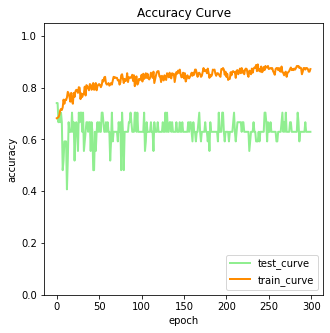

in epoch 299, test acc = 0.74 / 0.78(epoch:260) time: 12.5008s


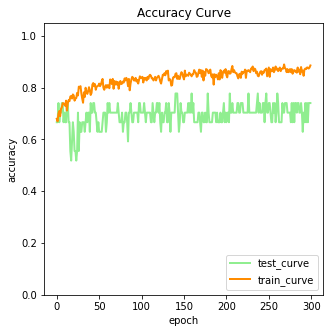

in epoch 299, test acc = 0.67 / 0.75(epoch:297) time: 12.4112s


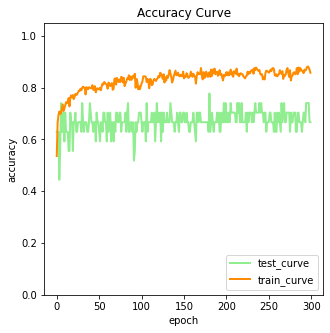

in epoch 299, test acc = 0.67 / 0.7(epoch:292) time: 12.3825s


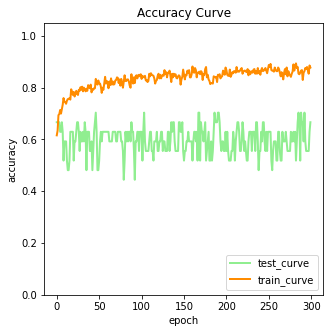

in epoch 299, test acc = 0.59 / 0.74(epoch:292) time: 12.3995s


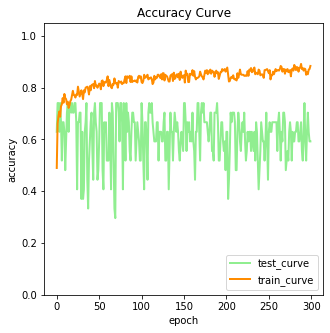

in epoch 299, test acc = 0.56 / 0.67(epoch:292) time: 12.3947s


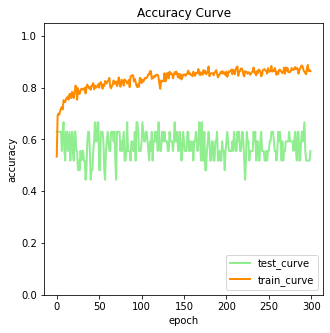

in epoch 299, test acc = 0.7 / 0.81(epoch:293) time: 12.3459s


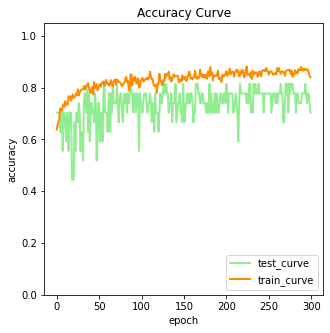

in epoch 299, test acc = 0.7 / 0.86(epoch:277) time: 12.338s


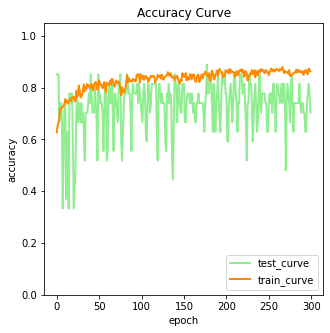

in epoch 299, test acc = 0.56 / 0.7(epoch:10) time: 12.3819s


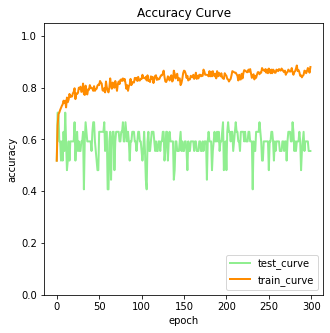

0.74709
roc:0.6210818283291867, sensitivity:0.30463684463684465, specificity:0.9375268120215287


In [3]:
for turn in range(TURN):
    # I.准备数据
    Fold_Datasets = Loader.get(n_splits=n_fold, drop=1, batch_size=100)

    _labels_list, _preds_list = [], [] # 用来画最后的ROC曲线
    acc_list_test = []
    for each_Fold in Fold_Datasets:
        time_ST = time.perf_counter()

        # 0.模型实例化
        model2 = MLP().to(device)

        loss_fn = nn.CrossEntropyLoss().to(device)
        optim = torch.optim.Adam(list(model2.parameters()), lr=LR)
        acc_list_turn = []

        # 1.作图需要的参数
        _X = []
        _Y_train = []
        _Y_test = []

        # 2.最终评价指标
        good_acc = [0, 0, 0]  # TODO: 增加
        good_con_mat = [None, None, None]
        good_epoch = 0
        good_preds_list, good_labels_list = [None, None, None], [None, None, None]


        # 3.数据集
        train_iter, test_iter = each_Fold

        # 4.开始训练
        for i in range(EPOCH):

            # 4.1 ------TRAIN PART-------
            model2.train()

            acc_for_train, count = 0, 0
            for train_batch in train_iter:
                [X1, X2, X3], labels = train_batch
                X1, X2, X3, labels = X1.to(device), \
                                     X2.to(device), \
                                     X3.to(device), \
                                     labels.to(device)

                # outputs_seq = model1(samples_seq)
                outputs_cor = model2(X1, X2, X3)
                # outputs = model3(outputs_seq, outputs_cor)
                outputs = outputs_cor
                # recording acc
                preds = outputs.cpu().argmax(1)
                acc = (preds == labels.cpu()).sum()
                count += len(labels)
                acc_for_train += acc

                # loss computing, backward
                labels = labels.long()
                loss = loss_fn(outputs, labels)
                optim.zero_grad()
                loss.backward()
                optim.step()
            _Y_train.append(torch.true_divide(acc_for_train, count))
            _X.append(i)

            # 4.2 ------TEST PART-------
            model2.eval()
            acc_for_test, count = 0, 0
            con_mat_test = np.zeros((2, 2))
            preds_list, labels_list = [], []
            for test_batch in test_iter:
                [X1, X2, X3], labels = test_batch
                X1, X2, X3 = X1.to(device), X2.to(device), X3.to(device)
                outputs_cor = model2(X1, X2, X3)
                outputs = outputs_cor

                preds = outputs.cpu().argmax(1)
                preds_list += preds.tolist()
                labels_list += labels.tolist()
                acc = (preds == labels).sum()
                count += len(labels)
                acc_for_test += acc

                for one in range(preds.shape[0]):
                    con_mat_test[int(labels[one].item()), preds[one]] += 1

            _Y_test.append(torch.true_divide(acc_for_test, count))

            # 4.2.1 打印总结
            print('\rin epoch {}, test acc = {} / {}(epoch:{})'.format(i, round(float(torch.true_divide(acc_for_test, count)), 2),
                                                                       round(float(np.mean(np.asarray(good_acc))), 2), good_epoch), end='')

            acc_list_turn.append(torch.true_divide(acc_for_test, count))

            # 4.2.2 记录最好的值
            b_acc = min(good_acc)
            ind_b_acc = good_acc.index(b_acc)
            if torch.true_divide(acc_for_test, count) >= b_acc:
                good_acc[ind_b_acc] = torch.true_divide(acc_for_test, count)
                good_con_mat[ind_b_acc] = con_mat_test
                good_epoch = i
                good_labels_list[ind_b_acc] = labels_list
                good_preds_list[ind_b_acc] = preds_list

        time_ED = time.perf_counter()
        print(' time: {}s'.format(round((time_ED - time_ST), 4)))

        # 5.记录所有的评价参数
        good_roc = 0
        good_sensitivity = 0
        good_specificity = 0
        for i in range(len(good_acc)):
            _preds_list += good_preds_list[i]
            _labels_list += good_labels_list[i]
            try:
                good_roc += Judge.mat_roc(good_con_mat[i].astype(dtype=int))
                good_sensitivity += Judge.mat_sensitivity(good_con_mat[i].astype(dtype=int))
                good_specificity += Judge.mat_specify(good_con_mat[i].astype(dtype=int))
            except:
                print('本次AUC参数计算有误')
        best_roc_list.append(good_roc / len(good_acc))
        best_sen_list.append(good_sensitivity / len(good_acc))
        best_spe_list.append(good_specificity / len(good_acc))

        acc_list_test.append(np.mean(np.asarray(good_acc)))

        if if_PRINT:
            # plt
            plt.figure(figsize=(5, 5))
            plt.plot(_X, _Y_test, c='lightgreen', lw=2, label='test_curve')
            plt.plot(_X, _Y_train, c='darkorange', lw=2, label='train_curve')
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.ylim([0, 1.05])
            plt.title('Accuracy Curve')
            plt.legend(loc="lower right")
            plt.show()

    # Fold结束，对所有fold的平均
    print(np.mean(np.asarray(acc_list_test)))
    print('roc:{}, sensitivity:{}, specificity:{}'.format(np.mean(np.asarray(best_roc_list)),
                                                          np.mean(np.asarray(best_sen_list)),
                                                          np.mean(np.asarray(best_spe_list))))
    acc_TURN.append(np.asarray(acc_list_test))

    Judge.auc_sens_spe_cal(_labels_list, _preds_list)